# Ames Housing Price Prediction

## Objective
The goal of this project is to predict residential housing prices in Ames, Iowa using machine learning techniques.

This notebook includes:
- Exploratory Data Analysis (EDA)
- Data preprocessing
- Model training and tuning
- Model evaluation


# =========================
# Import Required Libraries
# =========================

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
!pip install ydata_profiling
from ydata_profiling import ProfileReport

## Load Dataset


In [14]:
df = pd.read_csv("AmesHousing.csv")
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## Exploratory Data Analysis

I explored distributions, correlations, and relationships between features and the target variable to get better insights on the data.


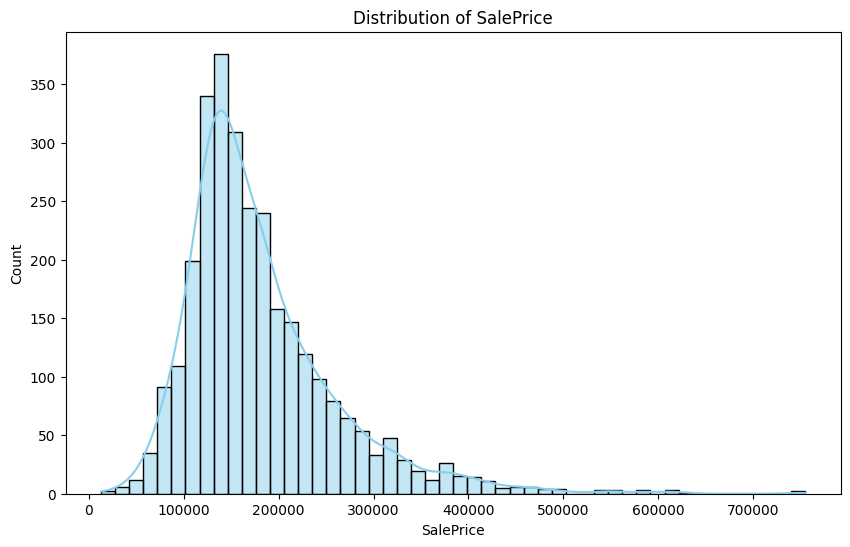

In [35]:
plt.figure(figsize=(10,6))
sns.histplot(df['SalePrice'], kde=True, bins=50, color='skyblue')
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Count')
plt.show()

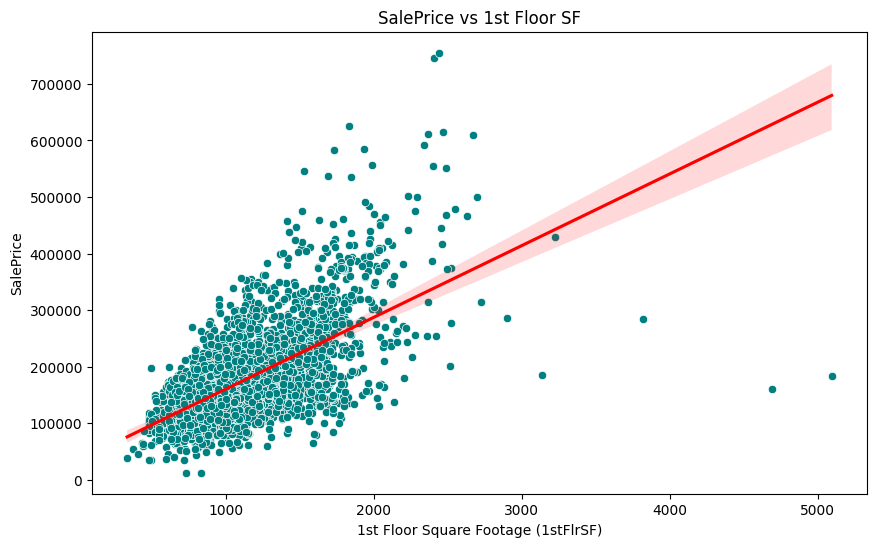

In [41]:

plt.figure(figsize=(10,6))
sns.scatterplot(x=df['1st Flr SF'], y=df['SalePrice'], color='teal')
sns.regplot(x=df['1st Flr SF'], y=df['SalePrice'], scatter=False, color='red')  # regression line
plt.title('SalePrice vs 1st Floor SF')
plt.xlabel('1st Floor Square Footage (1stFlrSF)')
plt.ylabel('SalePrice')
plt.show()


/tmp/ipython-input-8367918.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Utilities'], palette='pastel')


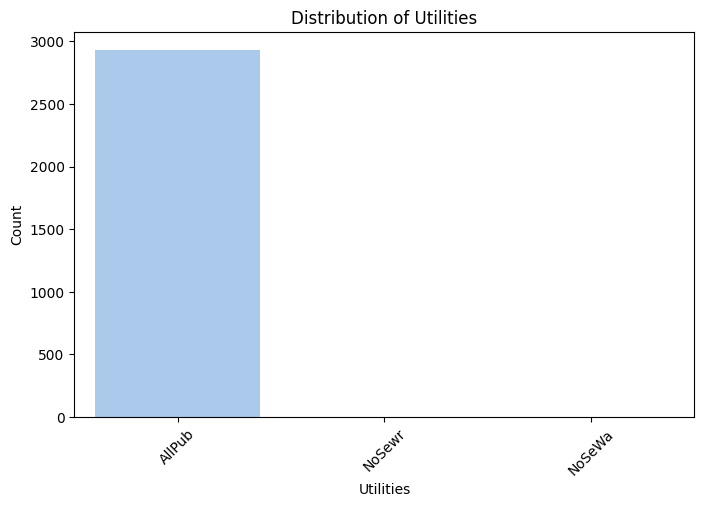

In [42]:
plt.figure(figsize=(8,5))

# Count plot for Utilities
sns.countplot(x=df['Utilities'], palette='pastel')
plt.title('Distribution of Utilities')
plt.xlabel('Utilities')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

- Sales Price is right skewed.
- Pool QC, Alley, Heating, Roof Style, Condition 2, Utilities, and Street have over 90% missing data.
- 1st Flr SF is highly corrolated with SalePrice.
- Utilities is highly ubalanced, has outliers.

### Data Preprocessing
Before building the machine learning model, we need to prepare the data:
- Drop irrelevant columns that don’t describe the house.
- Handle missing values in both numeric and categorical features.
- Convert categorical features into a numeric format so models can use them.
This ensures the dataset is clean, consistent, and ready for modeling.


In [21]:

#Does not help describe the house
df = df.drop(columns=["Order", "PID"])

# Separate features and target
X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

# Numeric pipeline
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

# Categorical pipeline
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Full preprocessing
preprocess = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

### Train-Test Split
We split the data into training and testing sets (80%-20%) to evaluate model performance on unseen data.
This ensures that our model generalizes well and does not just memorize the training data, or in other words overfitting.


In [33]:
# random_state=42 ensures reproducibility of the results
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [34]:
# --- Base model ---
# Initialize a Random Forest Regressor
# Random Forest is an ensemble method that reduces overfitting compared to a single decision tree
rf = RandomForestRegressor(random_state=42)

# --- Hyperparameter grid ---
# These are the parameters we will search over to find the best model:
param_grid = {
    "rf__n_estimators": [200, 300, 400, 500],      # number of trees in the forest
    "rf__max_depth": [None, 10, 20, 30, 40],       # maximum depth of each tree
    "rf__min_samples_split": [2, 5, 10],           # min samples required to split a node
    "rf__min_samples_leaf": [1, 2, 4],             # min samples required at a leaf node
    "rf__max_features": ["sqrt", "log2"]           # number of features to consider when looking for best split
}

# --- Full pipeline ---
# Combine preprocessing and model into a single pipeline
model = Pipeline([
    ("preprocess", preprocess),  # preprocessing numeric and categorical features
    ("rf", rf)                   # Random Forest model
])

# --- Randomized Search for hyperparameter tuning ---
# RandomizedSearchCV explores a subset of hyperparameter combinations to find the best model
# cv=5 means 5-fold cross-validation
# scoring="neg_root_mean_squared_error" means we optimize for RMSE
search = RandomizedSearchCV(
    model,
    param_grid,
    n_iter=20,                  # number of random combinations to try
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,                  # use all processors
    random_state=42
)

# --- Fit model ---
search.fit(X_train, y_train)

# Retrieve the best model after hyperparameter search
best_model = search.best_estimator_

# --- Predictions on test set ---
y_pred = best_model.predict(X_test)

# --- Evaluate model ---
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# --- Print results ---
print("Best Parameters:", search.best_params_)
print("RMSE:", rmse)
print("R²:", r2)


Best Parameters: {'rf__n_estimators': 500, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 2, 'rf__max_features': 'sqrt', 'rf__max_depth': None}
RMSE: 28776.816560714666
R²: 0.8967134118180118


### Predicted vs Actual Prices
This scatter plot compares the predicted SalePrice from our Random Forest model to the actual SalePrice.  
- Points close to the red line indicate accurate predictions.  
- Points far from the line show where the model under- or over-predicts.


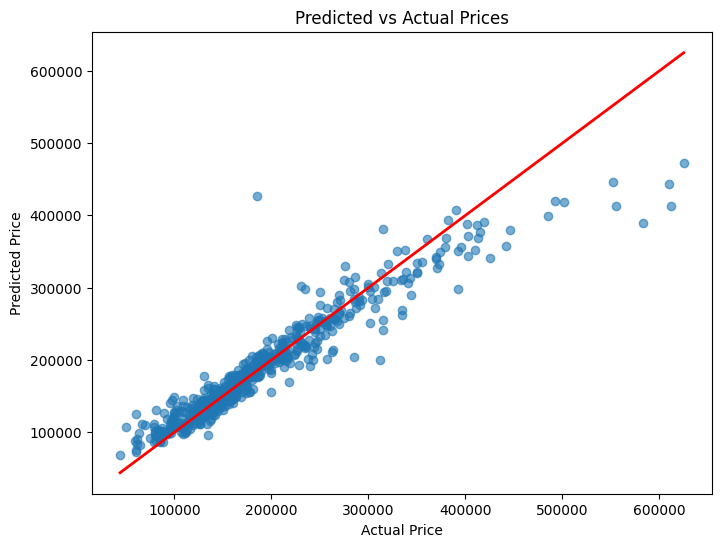

In [29]:
# --- Predicted vs Actual Prices ---
# This plot shows how well our model's predictions match the actual SalePrice values.
# The red diagonal line represents perfect predictions (Predicted = Actual).

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label='Predictions')  # scatter points

# Add diagonal line (perfect prediction)
max_val = max(max(y_test), max(y_pred))
min_val = min(min(y_test), min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r', linewidth=2, label='Perfect Prediction')

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices")
plt.legend()
plt.show()


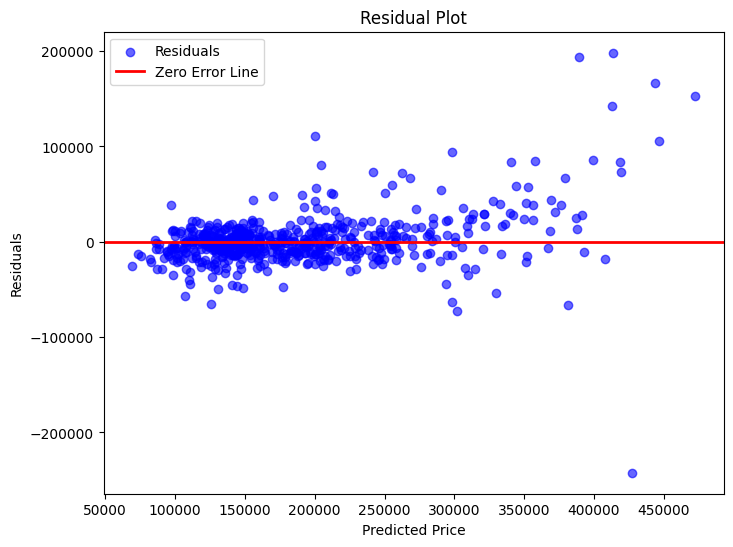

In [32]:
# --- Residual Plot ---
# This plot shows the residuals (difference between actual and predicted prices).
# Ideally, residuals should be randomly scattered around zero, indicating good model fit.

residuals = y_test - y_pred

plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.6, color='blue', label='Residuals')
plt.axhline(y=0, color='red', linewidth=2, label='Zero Error Line')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.legend()
plt.show()



### Top 10 Important Features
This plot shows the 10 most important features according to the Random Forest model.  
Features with higher importance values contribute more to predicting SalePrice.  
Understanding feature importance helps interpret the model and informs feature engineering.


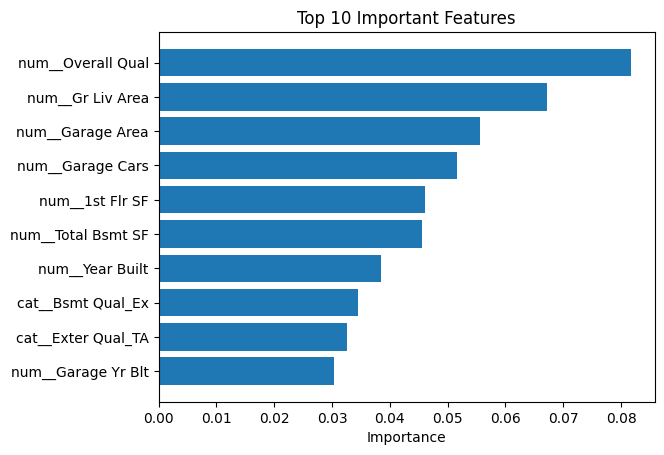

In [31]:
# --- Top 10 Feature Importances ---
# After preprocessing, get all feature names
feature_names = best_model.named_steps["preprocess"].get_feature_names_out()

# Get feature importance values from the Random Forest model
importances = best_model.named_steps["rf"].feature_importances_

# Create a DataFrame with features and their importance
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Select top 10 features
top10 = feature_importance_df.head(10)

# --- Plot top 10 feature importances ---
plt.figure(figsize=(10,6))
plt.barh(top10["Feature"], top10["Importance"], color='skyblue')
plt.xlabel("Importance")
plt.title("Top 10 Important Features in Random Forest Model")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


## Conclusion and Summary

In this project, we analyzed the Ames Housing dataset and built a machine learning model to predict house sale prices.

**Key Steps Taken:**
- Explored the dataset using EDA to understand distributions, missing values, and feature relationships.  
- Preprocessed the data by handling missing values, encoding categorical variables, and separating features from the target.  
- Split the dataset into training (80%) and testing (20%) sets to evaluate model performance on unseen data.  
- Built a Random Forest Regressor pipeline with hyperparameter tuning using RandomizedSearchCV to optimize model performance.  
- Evaluated the model using metrics and visualization, including predicted vs actual prices, residual plots, and feature importance analysis.

**Model Performance:**
- RMSE: $28,776.81  
- R²: 0.8967  

These metrics indicate that the model predicts house prices with really good accuracy. It explains 89.67% of the variance in SalePrice, and on average, predictions are off by approximately $28,776.81.

**Insights from Feature Importance:**
- The top features influencing house prices included overall quality, general living area, garage area.  
- Understanding these features can help inform property valuation and future feature engineering.  

**Next Steps / Considerations:**
- Consider experimenting with other models (e.g., Gradient Boosting, XGBoost) for potentially better performance.  
- Further feature engineering, such as creating interaction terms or transforming skewed features, could improve predictions.  
- Analyzing model residuals could reveal patterns that suggest additional preprocessing or model tuning.

Overall, this project demonstrates how machine learning can be applied to real-world housing data to make informed predictions and insights about factors affecting property prices.
